In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.utils import shuffle
from scipy.stats import skew
from __future__ import division
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import gc
from math import sqrt

from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [90]:
path = '../input/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

# 1. Exploratory

In [91]:
train.shape

(4459, 4993)

In [92]:
test.shape

(49342, 4992)

In [93]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [94]:
#Save the 'Id' column
train_ID = train['ID']
test_ID = test['ID']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

In [95]:
float_feats = train.dtypes[train.dtypes == "float64"].index
int_feats = train.dtypes[train.dtypes == "int64"].index
len(float_feats), len(int_feats), len(float_feats)+len(int_feats)

(1845, 3147, 4992)

In [96]:
print('check missing value {}'.format(train.isnull().sum().sum()))

check missing value 0


In [9]:
# TOO MUCH TIME TO COMPUTE!!!
# %%time
# corrmat = train.corr()
# corrmat['target'].sort_values()

# 2. Cleaning

In [97]:
gc.collect()

7

In [98]:
def display_skew(df, var):
    df.hist(column=var)
    print ('skewness: ' + str(skew(df[var])))

skewness: 2.0852647564165343


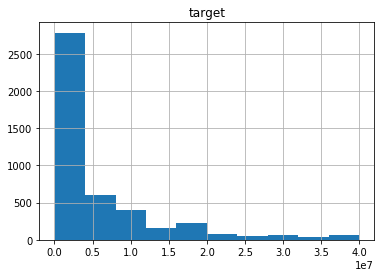

In [99]:
display_skew(train, 'target')

In [100]:
train["target"] = np.log1p(train["target"])
y_train = train.target.values

In [107]:
train.drop(["target"], axis = 1, inplace = True)

In [101]:
only_one = train.columns[train.nunique() == 1]

In [103]:
train.drop(only_one, axis = 1, inplace = True)
test.drop(only_one, axis = 1, inplace = True)

In [106]:
train.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,17.453097,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,13.304687,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,16.118096,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,14.508658,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,16.482739,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## 2.1 Remove duplicate columns

In [108]:
col_keeped = list((train.T.drop_duplicates().T).columns)
print('Number of duplicated columns: {}'.format(train.shape[1] - len(col_keeped)))

Number of duplicated columns: 5


In [109]:
train = train[col_keeped]
test = test[col_keeped]

# 3. Feature Engineering / Feature selection

### 3.1.4. Feature Ranking

Based on this method: https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [111]:
Y = y_train
X = train.as_matrix()

scaler = StandardScaler()
X = scaler.fit_transform(X)
colnames = train.columns

In [112]:
from sklearn.preprocessing import MinMaxScaler
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [113]:
# Finally let's run our Selection Stability method with Randomized Lasso
lasso = Lasso(alpha =0.5, random_state=1)
lasso.fit(X, Y)
ranks["lasso"] = ranking(np.abs(lasso.coef_), colnames)
print('finished')

finished


In [114]:
ENet = ElasticNet(alpha=0.05, l1_ratio=.9, random_state=3)
ENet.fit(X, Y)
ranks["ENet"] = ranking(np.abs(ENet.coef_), colnames)
print('finished')

finished


In [39]:
#KRR = KernelRidge(alpha=0.9, kernel='polynomial', degree=2, coef0=1)
#KRR.fit(X, Y)
#ranks["KRR"] = ranking(np.abs(KRR.dual_coef_), colnames)
#print('finished')

In [40]:
#from sklearn.feature_selection import RFE, f_regression

# Construct our Linear Regression model
#lr = LinearRegression()
#lr.fit(X,Y)
#stop the search when only the last feature is left
#rfe = RFE(lr, n_features_to_select=100, verbose =3 )
#rfe.fit(X,Y)
#ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

In [115]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=10,
                              learning_rate=0.05, 
                              n_estimators=300,
                              max_bin = 55, 
                              bagging_fraction = 0.9,
                              bagging_freq = 3, 
                              feature_fraction = 0.24,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =9,
                              min_sum_hessian_in_leaf = 13)
model_lgb.fit(X,Y)
ranks["LGB"] = ranking(model_lgb.feature_importances_, colnames)
print('finished')

finished


In [116]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	ENet	LGB	lasso	Mean
48df886f9	0.0	0.0	0.0	0.0
0deb4b6a8	0.0	0.0	0.0	0.0
34b15f335	0.0	0.0	0.0	0.0
a8cb14b00	0.0	0.0	0.0	0.0
2f0771a37	0.0	0.0	0.0	0.0
30347e683	0.0	0.0	0.0	0.0
d08d1fbe3	0.0	0.0	0.0	0.0
6ee66e115	0.0	0.0	0.0	0.0
20aa07010	0.3	0.37	0.0	0.22
dc5a8f1d8	0.0	0.0	0.0	0.0
11d86fa6a	0.0	0.0	0.0	0.0
77c9823f2	0.0	0.0	0.0	0.0
8d6c2a0b2	0.02	0.0	0.0	0.01
4681de4fd	0.0	0.0	0.0	0.0
adf119b9a	0.0	0.0	0.0	0.0
cff75dd09	0.0	0.0	0.0	0.0
96f83a237	0.0	0.0	0.0	0.0
b8a716ebf	0.0	0.0	0.0	0.0
6c7a4567c	0.0	0.0	0.0	0.0
4fcfd2b4d	0.0	0.0	0.0	0.0
f3b9c0b95	0.0	0.0	0.0	0.0
71cebf11c	0.0	0.0	0.0	0.0
d966ac62c	0.0	0.0	0.0	0.0
68b647452	0.0	0.0	0.0	0.0
c88d108c9	0.04	0.0	0.0	0.01
ff7b471cd	0.0	0.0	0.0	0.0
0d866c3d7	0.0	0.0	0.0	0.0
bc3f77679	0.0	0.0	0.0	0.0
bd8f989f1	0.0	0.02	0.0	0.01
0eff5bf95	0.0	0.0	0.0	0.0
22ed6dba3	0.0	0.04	0.0	0.01
92b13ebba	0.0	0.0	0.0	0.0
233c7c17c	0.0	0.0	0.0	0.0
2cb4d123e	0.0	0.0	0.0	0.0
87ffda550	0.0	0.14	0.0	0.05
822e49b95	0.0	0.02	0.0	0.01
316b978cd	0.0	0.0	0.0	0.0
d04

588106548	0.09	0.0	0.0	0.03
b219e3635	0.0	0.0	0.0	0.0
e2b4d4ef7	0.13	0.0	0.0	0.04
8646c43a7	0.0	0.0	0.0	0.0
8e8736fc8	0.0	0.04	0.0	0.01
e9770863c	0.0	0.0	0.0	0.0
15d57abf7	0.0	0.0	0.0	0.0
ba42e41fa	0.0	0.02	0.0	0.01
433d408b2	0.0	0.0	0.0	0.0
24303647f	0.0	0.0	0.0	0.0
a5fb00d9b	0.0	0.0	0.0	0.0
51ee03895	0.0	0.02	0.0	0.01
0bb06f4b5	0.0	0.0	0.0	0.0
122df5341	0.0	0.0	0.0	0.0
6a3b5a968	0.0	0.0	0.0	0.0
5fe3acd24	0.0	0.0	0.0	0.0
0aaed8bea	0.0	0.0	0.0	0.0
cd24eae8a	0.0	0.06	0.0	0.02
5a5168624	0.0	0.0	0.0	0.0
9666bfe76	0.0	0.0	0.0	0.0
e26299c3a	0.0	0.02	0.0	0.01
7121c40ee	0.0	0.02	0.0	0.01
ca67f1baa	0.0	0.0	0.0	0.0
8f21c5b89	0.0	0.0	0.0	0.0
6488c8200	0.0	0.06	0.0	0.02
f00a70ef6	0.0	0.0	0.0	0.0
788e6045c	0.0	0.0	0.0	0.0
1389b944a	0.0	0.0	0.0	0.0
578cf246c	0.0	0.0	0.0	0.0
2322dbbbb	0.0	0.02	0.0	0.01
6d1a3b508	0.0	0.0	0.0	0.0
bf59c51c3	0.0	0.0	0.0	0.0
c5e3535d2	0.0	0.0	0.0	0.0
1fcba48d0	0.0	0.0	0.0	0.0
33f6d3f51	0.0	0.0	0.0	0.0
0738fe5ff	0.1	0.02	0.0	0.04
a459b5f7d	0.0	0.0	0.0	0.0
9fcd078b0	0.0	0.

ee95f6389	0.0	0.0	0.0	0.0
fa2a340da	0.0	0.0	0.0	0.0
7dcc40cda	0.0	0.0	0.0	0.0
adc894423	0.0	0.08	0.0	0.03
44f2f419e	0.0	0.08	0.0	0.03
b335915da	0.0	0.0	0.0	0.0
b59179d17	0.0	0.0	0.0	0.0
a257e4bb9	0.0	0.0	0.0	0.0
25e2bcb45	0.0	0.0	0.0	0.0
cb5329038	0.0	0.0	0.0	0.0
d21f097bb	0.0	0.0	0.0	0.0
3c9db4778	0.0	0.0	0.0	0.0
5f9879270	0.0	0.06	0.0	0.02
698d05d29	0.0	0.02	0.0	0.01
d83da5921	0.0	0.0	0.0	0.0
c7775aabf	0.0	0.0	0.0	0.0
7b1ddbabf	0.0	0.0	0.0	0.0
5b9dfbf38	0.0	0.0	0.0	0.0
3f6246360	0.0	0.0	0.0	0.0
aeff360c7	0.0	0.0	0.0	0.0
d9fa0485a	0.0	0.0	0.0	0.0
4f2f6b0b3	0.0	0.04	0.0	0.01
b791ce9aa	0.0	0.22	0.0	0.07
e5ac02d3c	0.0	0.0	0.0	0.0
62c547c8e	0.0	0.02	0.0	0.01
9379a6483	0.0	0.0	0.0	0.0
4a3da18d3	0.05	0.0	0.0	0.02
4a921e941	0.0	0.0	0.0	0.0
5a99d7f30	0.0	0.0	0.0	0.0
6fff36435	0.0	0.0	0.0	0.0
188a6e279	0.0	0.0	0.0	0.0
571380d69	0.0	0.0	0.0	0.0
b2f4d49d1	0.0	0.0	0.0	0.0
70f4f1129	0.0	0.0	0.0	0.0
a240f6da7	0.0	0.0	0.0	0.0
fec5eaf1a	0.0	0.02	0.0	0.01
9fa984817	0.03	0.0	0.0	0.01
177571d9c	0.0	0.0	

In [117]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

In [119]:
meanplot.head(50)

,Feature,Mean Ranking
4131,f190486d6,0.67
2378,58e2e02e6,0.50
2616,9fd594eec,0.37
3467,eeb9cd3aa,0.30
834,6eef030c1,0.28
8,20aa07010,0.22
3572,58232a6fb,0.20
2876,2087ed398,0.19
3223,ced6a7e91,0.19
4021,15ace8c9f,0.18


In [120]:
res = meanplot[meanplot['Mean Ranking'] >= 0.09]
subset_col = list(res['Feature'].unique())

In [121]:
subset_col

['f190486d6',
 '58e2e02e6',
 '9fd594eec',
 'eeb9cd3aa',
 '6eef030c1',
 '20aa07010',
 '58232a6fb',
 '2087ed398',
 'ced6a7e91',
 '15ace8c9f',
 'fb387ea33',
 'b43a7cfd5',
 '402b0d650',
 'f514fdb2e',
 '371ff7a11',
 '58e056e12',
 '1702b5bf0',
 '2c6c62b54',
 '5f341a818',
 'bb1113dbb',
 'fb0f5dbfe',
 'df838756c',
 '2288333b4',
 '1d9078f84',
 'f32763afc',
 '0bb96a2ae',
 'bf6e38e39',
 '37f57824c',
 '64e483341',
 '5b714cd7a',
 '9f7b782ac',
 '5a798adc1',
 'ab7764ead',
 'd6bb78916',
 'f74e8f13d',
 'c089837ee',
 'c47340d97',
 '43782ef36',
 '98af380ad',
 '58ed8fb53',
 'b9ba17eb6',
 'f41af7c85',
 'ba4ceabc5',
 '4edc3388d',
 '26ab20ff9',
 'b30e932ba']

In [122]:
len(subset_col)

46